In [1]:
import sys, numpy, math
import scipy.stats as scipystats
import matplotlib.pyplot as plt
import numpy as np
import re
import os

%matplotlib inline

# Deemed colorblind safe: http://colorbrewer2.org/#type=diverging&scheme=PiYG&n=4
highConfColor     ='#1b9e77'
medConfColor      ='#7570b3'
lowConfColor      ='#d95f02'
unclassifiedColor ='black'

In [2]:
import somaticseq.genomicFileHandler.genomic_file_handlers as genome

In [3]:
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/')
sys.path.append('/home/lethalfang/apps/seqc2/somaticseq/utilities')

from bedFileHandler import BedFile

In [4]:
def R(x, y):
    assert len(x) == len(y)
    x1 = []
    y1 = []
    for x_i, y_i in zip(x,y):
        if math.isfinite(x_i) and math.isfinite(y_i):
            x1.append(x_i)
            y1.append(y_i)
            
    return scipystats.pearsonr(x1,y1)[0]

In [5]:
reference_dir = '../../../../HCC1395/HighConfidenceCalls/truth_v1.1/'

superset_file = os.path.join(reference_dir, 'sSNV.MSDUKT.superSet.v1.2.vcf.gz')

tumor100 = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-0_mergeThree.bwa.dedup.txt' )
tumor75  = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_3-1_mergeThree.bwa.dedup.txt' )
tumor50  = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-1_mergeThree.bwa.dedup.txt' )
tumor20  = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-4_mergeThree.bwa.dedup.txt' )
tumor10  = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-9_mergeThree.bwa.dedup.txt' )
tumor5   = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-19_mergeThree.bwa.dedup.txt')
tumor0   = os.path.join(reference_dir, 'SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_0-1_mergeThree.bwa.dedup.txt' )

vafFiles = [tumor100, tumor75, tumor50, tumor20, tumor10, tumor5, tumor0]

In [6]:
spp_vaf = os.path.join(reference_dir, 'SPP.Final.VAF/sSNV.v1.1.SPP.tsv.gz' )

In [7]:
sppVafs = {}
for frac_i, file_i in zip([100, 75, 50, 20, 10, 5, 0], vafFiles):
    print(frac_i, file_i)
    with genome.open_textfile(file_i) as fn:
        line_i = fn.readline().rstrip()
        
        for line_i in fn:
            
            item = line_i.rstrip().split('\t')
            
            variant_id = item[0], int(item[1]), item[2], item[3]
            vaf_i = float(item[6])
            
            if variant_id not in sppVafs:
                sppVafs[variant_id] = {}
                
            sppVafs[variant_id][frac_i] = vaf_i

100 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-0_mergeThree.bwa.dedup.txt
75 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_3-1_mergeThree.bwa.dedup.txt
50 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-1_mergeThree.bwa.dedup.txt
20 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-4_mergeThree.bwa.dedup.txt
10 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-9_mergeThree.bwa.dedup.txt
5 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_1-19_mergeThree.bwa.dedup.txt
0 ../../../../HCC1395/HighConfidenceCalls/truth_v1.1/SPP/VAF.sSNV.MSDUKT.dedup_all_SPP_GT_0-1_mergeThree.bwa.dedup.txt


In [8]:
goldset_VAF = []

VAF100 = []
VAF75  = []
VAF50  = []
VAF20  = []
VAF10  = []
VAF5   = []
VAF0   = []
SPP_VAFs = [ VAF100, VAF75, VAF50, VAF20, VAF10, VAF5, VAF0 ]

snv_highConf     = []
snv_medConf      = []
snv_lowConf      = []
snv_Unclassified = []

with genome.open_textfile(superset_file) as superset:
    
    line_i = superset.readline().rstrip()
    
    while line_i.startswith('#'):
        line_i = superset.readline().rstrip()
            
    while line_i:
        
        vcf_i = genome.Vcf_line(line_i)
        variant_id = vcf_i.chromosome, vcf_i.position, vcf_i.refbase, vcf_i.altbase
        
        if ('ArmLossInNormal' not in vcf_i.info) and (variant_id in sppVafs):

            if re.search(r'HighConf', vcf_i.filters):
                snv_highConf.append( True )
                snv_medConf.append( False )
                snv_lowConf.append( False )
                snv_Unclassified.append( False )
                
            elif re.search(r'MedConf', vcf_i.filters):
                snv_highConf.append( False )
                snv_medConf.append( True )
                snv_lowConf.append( False )
                snv_Unclassified.append( False )
                
            elif re.search(r'LowConf', vcf_i.filters):
                snv_highConf.append( False )
                snv_medConf.append( False )
                snv_lowConf.append( True )
                snv_Unclassified.append( False )
                
            elif re.search(r'Unclassified', vcf_i.filters):
                snv_highConf.append(  False )
                snv_medConf.append( False )
                snv_lowConf.append( False )
                snv_Unclassified.append( True )
            
            goldset_vaf = float( vcf_i.get_info_value('bwaTVAF') )
            goldset_VAF.append(goldset_vaf)
            
            # Get the VAF from SPP
            VAF100.append( sppVafs[variant_id][100] )
            VAF75.append( sppVafs[variant_id][75] )
            VAF50.append( sppVafs[variant_id][50] )
            VAF20.append( sppVafs[variant_id][20] )
            VAF10.append( sppVafs[variant_id][10] )
            VAF5.append( sppVafs[variant_id][5] )
            VAF0.append( sppVafs[variant_id][0] )
        
        line_i = superset.readline().rstrip()

In [9]:
snv_highConf     = np.array(snv_highConf,   dtype=bool)
snv_medConf      = np.array(snv_medConf,     dtype=bool)
snv_lowConf      = np.array(snv_lowConf,  dtype=bool)
snv_Unclassified = np.array(snv_Unclassified, dtype=bool)

goldset_VAF = np.array(goldset_VAF)
VAF100      = np.array(VAF100)
VAF75       = np.array(VAF75)
VAF50       = np.array(VAF50)
VAF20       = np.array(VAF20)
VAF10       = np.array(VAF10)
VAF5        = np.array(VAF5)
VAF0        = np.array(VAF0)

In [10]:
sppVafs[variant_id]

{100: 0.42410714285714285,
 75: 0.3814814814814815,
 50: 0.22021660649819494,
 20: 0.07903780068728522,
 10: 0.04745762711864407,
 5: 0.02214022140221402,
 0: 0.0}

In [11]:
len(snv_highConf), len(goldset_VAF), len(VAF10), sum(snv_highConf), sum(snv_medConf)

(117996, 117996, 117996, 37397, 2498)

In [12]:
M = np.linspace(0,0.6,13)
print(M)

highconfs     = {}
medconfs      = {}
lowconfs      = {}
unclassifieds = {}

highconf_vafs     = []
highconf_rses     = []
medconf_vafs      = []
medconf_rses      = []
lowconf_vafs      = []
lowconf_rses      = []
unclassified_vafs = []
unclassified_rses = []

for i in M:
    highconfs[i]     = []
    medconfs[i]      = []
    lowconfs[i]      = []
    unclassifieds[i] = []

for i, vaf_i in enumerate(goldset_VAF):
    
    #ith_M = np.argmin( abs(vaf_i-M) )
    ith_M = 0
    for vaf_j in M[1:]:
        if vaf_i < vaf_j:
            break
        else:
            ith_M += 1
    
    vaf_bracket = M[ith_M]
    rse = ((VAF100[i] - vaf_i)**2 + (VAF75[i] - 0.75*vaf_i)**2  + (VAF50[i] - 0.5*vaf_i)**2 + (VAF20[i] - 0.20*vaf_i)**2 + (VAF10[i] - 0.1*vaf_i)**2 + (VAF5[i] - 0.05*vaf_i)**2 + (VAF0[i] - 0*vaf_i)**2 )**0.5 / vaf_i
    if rse >= sys.float_info.max:
        rse = sys.float_info.max
    
    if not np.isnan(rse):
        if snv_highConf[i]:
            highconfs[vaf_bracket].append(rse)
            highconf_vafs.append(vaf_i)
            highconf_rses.append( 1/rse )
    
        elif snv_medConf[i]:
            medconfs[vaf_bracket].append(rse)
            medconf_vafs.append(vaf_i)
            medconf_rses.append( 1/rse )
    
        elif snv_lowConf[i]:
            lowconfs[vaf_bracket].append(rse)
            lowconf_vafs.append(vaf_i)
            lowconf_rses.append( 1/rse )
    
        elif snv_Unclassified[i]:
            unclassifieds[vaf_bracket].append(rse)
            unclassified_vafs.append(vaf_i)
            unclassified_rses.append( 1/rse )

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6 ]


/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/home/lethalfang/anaconda3/envs/plt30/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


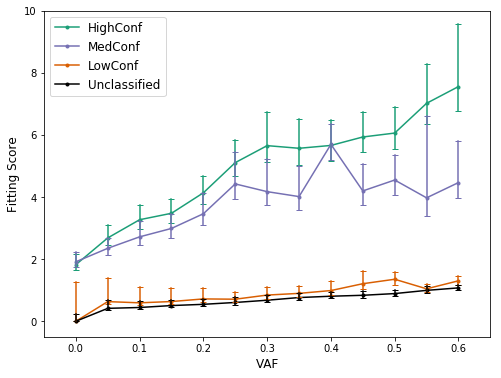

In [13]:
plt.figure(figsize=(8,6))

arse_highconf           = []
arse_highconf_upper     = []
arse_highconf_lower     = []
arse_medconf            = []
arse_medconf_upper      = []
arse_medconf_lower      = []
arse_lowconf            = []
arse_lowconf_upper      = []
arse_lowconf_lower      = []
arse_unclassified       = []
arse_unclassified_upper = []
arse_unclassified_lower = []


for vaf_i in M:
    
    try:
        data_i = np.array(highconfs[vaf_i])
        
        data_j = data_i[ data_i<=np.percentile(data_i, 84) ]
        data_k = data_i[ data_i>=np.percentile(data_i, 16) ]

        arse_i = 1/np.mean(data_i)
        arse_j = 1/np.mean(data_j)
        arse_k = 1/np.mean(data_k)
        
        upper_i = 1 / (np.mean(data_i) - np.std(data_i))
        lower_i = 1 / (np.mean(data_i) + np.std(data_i))        

    except ZeroDivisionError:
        arse_i = float('nan')
    except IndexError:
        arse_i = float('nan')
    
    arse_highconf.append( arse_i )
    arse_highconf_upper.append( arse_j )
    arse_highconf_lower.append( arse_k )
    
    try:
        data_i = np.array(medconfs[vaf_i])
        data_j = data_i[ data_i<=np.percentile(data_i, 84) ]
        data_k = data_i[ data_i>=np.percentile(data_i, 16) ]

        arse_i = 1/np.mean(data_i)
        arse_j = 1/np.mean(data_j)
        arse_k = 1/np.mean(data_k)
        
        upper_i = 1 / (np.mean(data_i) - np.std(data_i))
        lower_i = 1 / (np.mean(data_i) + np.std(data_i))        

    except ZeroDivisionError:
        arse_i = float('nan')
    except IndexError:
        arse_i = float('nan')

    arse_medconf.append( arse_i )
    arse_medconf_upper.append( arse_j )
    arse_medconf_lower.append( arse_k )

    try:
        data_i = np.array(lowconfs[vaf_i])
        data_j = data_i[ data_i<=np.percentile(data_i, 84) ]
        data_k = data_i[ data_i>=np.percentile(data_i, 16) ]

        arse_i = 1/np.mean(data_i)
        arse_j = 1/np.mean(data_j)
        arse_k = 1/np.mean(data_k)
        
        upper_i = 1 / (np.mean(data_i) - np.std(data_i))
        lower_i = 1 / (np.mean(data_i) + np.std(data_i))        

    except ZeroDivisionError:
        arse_i = float('nan')
    except IndexError:
        arse_i = float('nan')

    arse_lowconf.append( arse_i )
    arse_lowconf_upper.append( arse_j )
    arse_lowconf_lower.append( arse_k )
    
    try:
        data_i = np.array(unclassifieds[vaf_i])
        data_j = data_i[ data_i<=np.percentile(data_i, 84) ]
        data_k = data_i[ data_i>=np.percentile(data_i, 16) ]

        arse_i = 1/np.mean(data_i)
        arse_j = 1/np.mean(data_j)
        arse_k = 1/np.mean(data_k)
        
        upper_i = 1 / (np.mean(data_i) - np.std(data_i))
        lower_i = 1 / (np.mean(data_i) + np.std(data_i))        
        
    except ZeroDivisionError:
        arse_i = float('nan')
    except IndexError:
        arse_i = float('nan')

    arse_unclassified.append( arse_i )
    arse_unclassified_upper.append( arse_j )
    arse_unclassified_lower.append( arse_k )

    
plt.plot(M, arse_highconf,     marker = '.', color=highConfColor,)
plt.plot(M, arse_medconf,      marker = '.', color=medConfColor,)
plt.plot(M, arse_lowconf,      marker = '.', color=lowConfColor,)
plt.plot(M, arse_unclassified, marker = '.', color=unclassifiedColor,)


plt.legend(('HighConf', 'MedConf', 'LowConf', 'Unclassified'), fontsize=12)
plt.xlabel('VAF', size=12)
plt.ylabel('Fitting Score', size=12)

plt.plot(M, arse_highconf_upper,     linestyle = 'None', marker='_', color=highConfColor,)
plt.plot(M, arse_highconf_lower,     linestyle = 'None', marker='_', color=highConfColor,)
plt.plot(M, arse_medconf_upper,      linestyle = 'None', marker='_', color=medConfColor,)
plt.plot(M, arse_medconf_lower,      linestyle = 'None', marker='_', color=medConfColor,)
plt.plot(M, arse_lowconf_upper,      linestyle = 'None', marker='_', color=lowConfColor,)
plt.plot(M, arse_lowconf_lower,      linestyle = 'None', marker='_', color=lowConfColor,)
plt.plot(M, arse_unclassified_upper, linestyle = 'None', marker='_', color=unclassifiedColor,)
plt.plot(M, arse_unclassified_lower, linestyle = 'None', marker='_', color=unclassifiedColor,)

for x_i, y_i, y_j in zip(M, arse_highconf_upper, arse_highconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=highConfColor,)

for x_i, y_i, y_j in zip(M, arse_medconf_upper, arse_medconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=medConfColor,)

for x_i, y_i, y_j in zip(M, arse_lowconf_upper, arse_lowconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=lowConfColor,)

for x_i, y_i, y_j in zip(M, arse_unclassified_upper, arse_unclassified_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=unclassifiedColor,)


plt.ylim((-0.5, 10))
plt.xlim((-0.05, 0.65))    

plt.savefig('../Main_Figures/Fig_2c_fitting_scores.pdf', bbox_inches='tight')

(-0.05, 0.65)

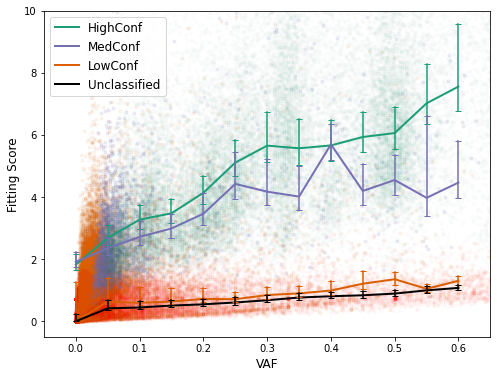

In [13]:
plt.figure(figsize=(8,6))

plt.plot(M, arse_highconf,     color=highConfColor, linewidth=2)
plt.plot(M, arse_medconf,      color=medConfColor,  linewidth=2)
plt.plot(M, arse_lowconf,      color=lowConfColor,  linewidth=2)
plt.plot(M, arse_unclassified, color=unclassifiedColor,   linewidth=2)

plt.legend(('HighConf', 'MedConf', 'LowConf', 'Unclassified'), fontsize=12)

plt.scatter(unclassified_vafs, unclassified_rses, marker='.', color='red',   alpha=0.015)
plt.scatter(lowconf_vafs,      lowconf_rses,      marker='.', color=lowConfColor,  alpha=0.06)
plt.scatter(medconf_vafs,      medconf_rses,      marker='.', color=medConfColor,  alpha=0.1)
plt.scatter(highconf_vafs,     highconf_rses,     marker='.', color=highConfColor, alpha=0.01)


plt.plot(M, arse_highconf_upper,     linestyle = 'None', marker='_', color=highConfColor,)
plt.plot(M, arse_highconf_lower,     linestyle = 'None', marker='_', color=highConfColor,)
plt.plot(M, arse_medconf_upper,      linestyle = 'None', marker='_', color=medConfColor,)
plt.plot(M, arse_medconf_lower,      linestyle = 'None', marker='_', color=medConfColor,)
plt.plot(M, arse_lowconf_upper,      linestyle = 'None', marker='_', color=lowConfColor,)
plt.plot(M, arse_lowconf_lower,      linestyle = 'None', marker='_', color=lowConfColor,)
plt.plot(M, arse_unclassified_upper, linestyle = 'None', marker='_', color=unclassifiedColor,)
plt.plot(M, arse_unclassified_lower, linestyle = 'None', marker='_', color=unclassifiedColor,)

for x_i, y_i, y_j in zip(M, arse_highconf_upper, arse_highconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=highConfColor,)

for x_i, y_i, y_j in zip(M, arse_medconf_upper, arse_medconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=medConfColor,)

for x_i, y_i, y_j in zip(M, arse_lowconf_upper, arse_lowconf_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=lowConfColor,)

for x_i, y_i, y_j in zip(M, arse_unclassified_upper, arse_unclassified_lower):
    plt.plot((x_i, x_i), (y_i, y_j), color=unclassifiedColor,)



plt.xlabel('VAF', size=12)
plt.ylabel('Fitting Score', size=12)
plt.ylim((-0.5, 10))
plt.xlim((-0.05, 0.65))